In [1]:
from DLtools.Data_preprocess import load_data
from DLtools.evaluation_rec import real_eva_error,error_rec,list_eva_error

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten, LSTM, RepeatVector,TimeDistributed,Input
from tensorflow.keras.callbacks import EarlyStopping

np.random.seed(42)

Inspired
https://www.analyticsvidhya.com/blog/2020/10/multivariate-multi-step-time-series-forecasting-using-stacked-lstm-sequence-to-sequence-autoencoder-in-tensorflow-2-0-keras/

In [2]:
def move_column_inplace(df, col, pos):
    col = df.pop(col)
    df.insert(pos, col.name, col)
    return df

In [3]:
r='data/instant_data/rain_small.csv'
w='data/instant_data/water_small.csv'
rw = load_data(r,w)
df =rw.df.resample('d').mean().astype('float32')

df = df["2013-01-01":"2017-12-31"].interpolate(limit=360)
# data = df.fillna(0)
# data = df.interpolate(limit=7)

DataFrame shape: (465169, 35)


In [4]:
TARGET = 'CPY015_w'
df = move_column_inplace(df,TARGET,0)
df.head()

,CPY015_w,CHM002_r,CHM004_r,CHM006_r,CPY004_r,CPY009_r,CPY010_r,CPY015_r,KWN002_r,NAN006_r,...,CPY010_w,KWN002_w,NAN009_w,NAN010_w,NAN011_w,NAN012_w,NAN013_w,PIN001_w,PIN004_w,THA001_w
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,0.797222,0.0,NaN,NaN,0.0,0.0,0.0,0.0,NaN,0.0,...,0.905664,NaN,NaN,NaN,NaN,NaN,NaN,119.359161,40.765835,15.046528
2013-01-02,0.636250,0.0,NaN,NaN,0.0,0.0,0.0,0.0,NaN,0.0,...,0.793056,NaN,NaN,NaN,NaN,NaN,NaN,119.383331,40.826023,15.028889
2013-01-03,0.581458,0.0,NaN,NaN,0.0,0.0,0.0,0.0,NaN,0.0,...,0.771111,NaN,NaN,NaN,NaN,NaN,NaN,119.499649,40.822639,14.972569
2013-01-04,0.532153,0.0,NaN,NaN,0.0,0.0,0.0,0.0,NaN,0.0,...,0.681250,NaN,NaN,NaN,NaN,NaN,NaN,119.406433,40.872360,14.956528
2013-01-05,0.530139,0.0,NaN,NaN,0.0,0.0,0.0,0.0,NaN,0.2,...,0.671736,NaN,NaN,NaN,NaN,NaN,NaN,119.403290,40.996559,14.932222


In [5]:
def split_series(series, n_past, n_future):
    # n_past ==> no of past observations
    # n_future ==> no of future observations 
    X, y = list(), list()
    for window_start in range(len(series)):
        past_end = window_start + n_past
        future_end = past_end + n_future
        if future_end > len(series):
            break
        # slicing the past and future parts of the window
        past, future = series[window_start:past_end, :], series[past_end:future_end, :]
        X.append(past)
        y.append(future)
    return np.array(X), np.array(y)

######################
n_past = 14
n_future = 7 
n_features = 35
# SCALE
scaler_tar = MinMaxScaler()
scaler_tar.fit(df[TARGET].to_numpy().reshape(-1,1))
data=df.fillna(0)
scaler = MinMaxScaler()
data[data.columns] = scaler.fit_transform(data[data.columns])

# Train-Test split
split_pt = int(data.shape[0]*.7)
train,test = data.iloc[:split_pt,:],data.iloc[split_pt:,:]

#Split XY
X_train, y_train = split_series(train.values,n_past, n_future)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],n_features))
y_train = y_train[:,:,0]
X_test, y_test = split_series(test.values,n_past, n_future)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],n_features))
y_test = y_test[:,:,0]

print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(1258, 14, 35) (1258, 7)
(528, 14, 35) (528, 7)


# Encode,decode from machinery website

In [6]:
verbose, epochs, batch_size = 0, 70, 16
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]
# define model
model = Sequential()
model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
model.add(RepeatVector(n_outputs))                                  # Decoder 
model.add(LSTM(200, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(100, activation='relu')))
model.add(TimeDistributed(Dense(1)))
model.compile(loss='mse', optimizer='adam')
model.summary()
callback_early_stopping = EarlyStopping(monitor='val_loss',patience=10, verbose=2)
reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)
# callbacks = [callback_early_stopping,reduce_lr]
callbacks = [reduce_lr]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 200)               188800    
_________________________________________________________________
repeat_vector (RepeatVector) (None, 7, 200)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 7, 200)            320800    
_________________________________________________________________
time_distributed (TimeDistri (None, 7, 100)            20100     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 7, 1)              101       
Total params: 529,801
Trainable params: 529,801
Non-trainable params: 0
_________________________________________________________________


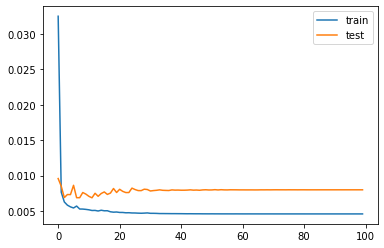

In [7]:
history = model.fit(X_train,y_train,epochs=100,validation_data=(X_test,y_test),batch_size=32,verbose=0,callbacks=callbacks)

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [72]:
# get prdict result as once
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)

mse, nse,r2 = list_eva_error(y_train, trainPredict,n_future)
Tmse, Tnse,Tr2 = list_eva_error(y_test, testPredict,n_future)

# for d in range(n_future):
#     # print("Day{}........MSE:{:.3f},NSE:{:.3f}| (test)MSE:{:.3f},NSE:{:.3f}".format(d+1,mse[d],nse[d],Tmse[d],Tnse[d]))
#     Y = y_train[:,d]
#     Yhat = trainPredict[:,d]
#     Y_t = y_test[:,d]
#     Yhat_t = testPredict[:,d]

#     yhat_series = pd.Series(predictions, index=)

#     plt.figure(figsize=(15,5))
#     plt.plot(Y, label = "Actual")
#     plt.plot(Yhat, label = "Predict")
#     plt.title('TRAIN Day{}\n'.format(d+1)+'Water Level CPY015 ARIMA Forecast vs Actuals\n'+'Test MSE: %.3f | Test NSE: %.3f | R2 score: %.3f' % (mse[d],nse[d],r2[d]))
#     plt.legend()
  

#     plt.figure(figsize=(15,5))
#     plt.plot(Y_t, label = "Actual")
#     plt.plot(Yhat_t, label = "Predict")
#     plt.title('TESTDay{}\n'.format(d+1)+'Water Level CPY015 ARIMA Forecast vs Actuals\n'+'Test MSE: %.3f | Test NSE: %.3f | R2 score: %.3f' % (Tmse[d],Tnse[d],Tr2[d]))
#     plt.legend()
#     plt.show()
    

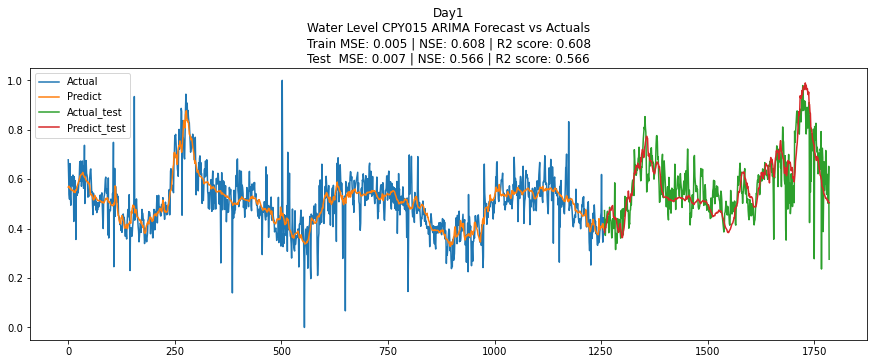

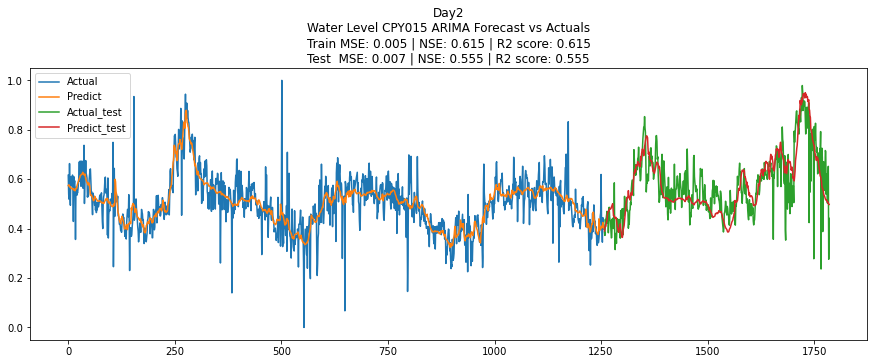

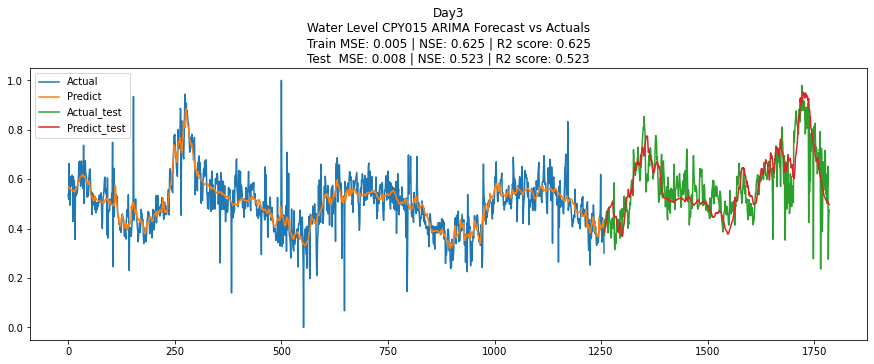

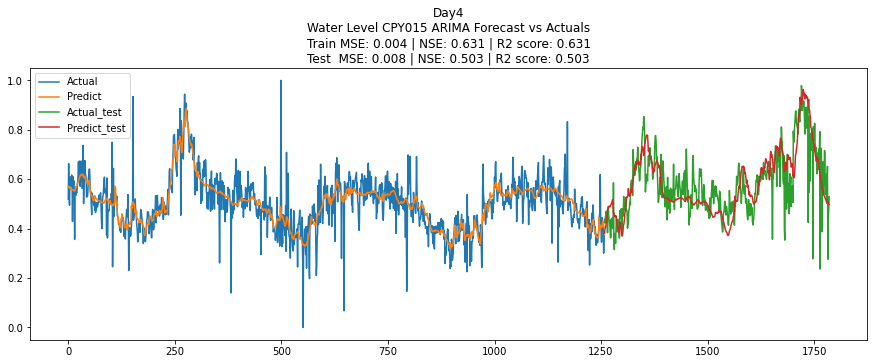

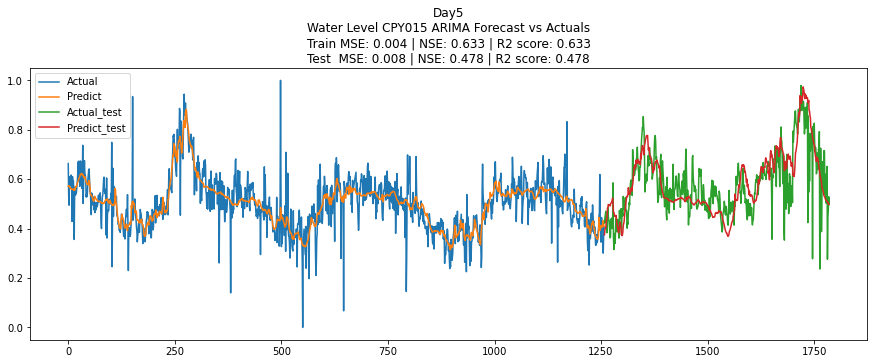

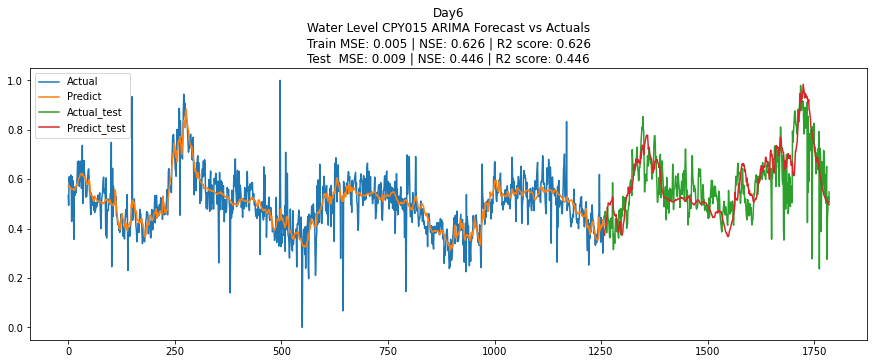

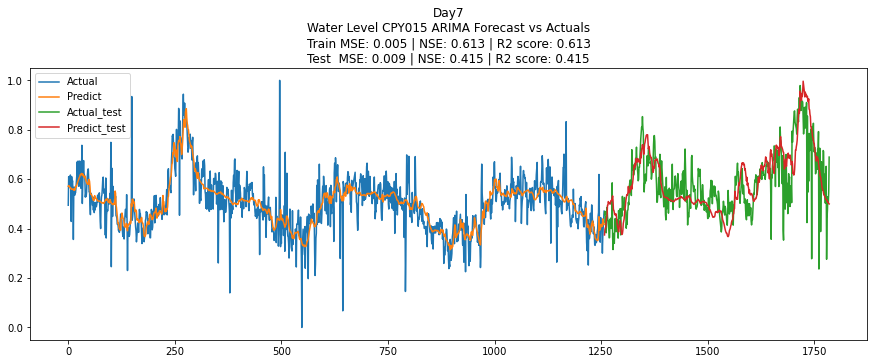

In [71]:
index = np.arange(len(y_train)+len(y_test))

for d in range(n_future):
    Y= pd.Series(data=y_train[:,d],index=index[:len(y_train)])
    Yhat = pd.Series(data=(trainPredict[:,d].ravel()),index=index[:len(y_train)])
    Y_t= pd.Series(data=y_test[:,d],index=index[-len(y_test):])
    Yhat_t = pd.Series(data=(testPredict[:,d].ravel()),index=index[-len(y_test):])

    
    plt.figure(figsize=(15,5))
    plt.plot(Y, label = "Actual")
    plt.plot(Yhat, label = "Predict")
    
    plt.plot(Y_t, label = "Actual_test")
    plt.plot(Yhat_t, label = "Predict_test")
    plt.title('Day{}\n'.format(d+1)+'Water Level CPY015 ARIMA Forecast vs Actuals\n'+'Train MSE: %.3f | NSE: %.3f | R2 score: %.3f' % (mse[d],nse[d],r2[d])+'\nTest  MSE: %.3f | NSE: %.3f | R2 score: %.3f' % (Tmse[d],Tnse[d],Tr2[d]))
    
    plt.legend()
    plt.show()
    


In [61]:
y_test[:,d].shape,len(y_test)

((528,), 528)